# Visualization graphs and results for Typhon

### Load Librairies

In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import itertools

### To have a pretty print on the graphs

In [2]:
pretty_print = {
    'auc': 'AUC',
    'loss': 'Loss',
    'accuracy': 'Accuracy',
    'accuracy-top-2': 'Top-2 Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1score': 'F1-Score',
    'f1-score': 'F1-Score',
    'specificity': 'Specificity',
    'train': 'Train',
    'validation': 'Val',
    'test': 'Test',
    'trained': 'Training',
    'specialized': 'Specialization',
    'iou': 'IoU',
    'dice': 'Dice Score',
    'hd': 'HD',
    'BUS_SELECTED': 'UDIAT',
    'BUS_VAL_RESHUFFLED': 'UDIAT',
    'UDIAT': 'BUSI',
    'Cifar10': 'CIFAR-10',
    'Cifar100': 'CIFAR-100',
    'Cifar100groups': 'CIFAR-100',
    'Prostate': 'Prostate',
    'Brain': 'Brain',
    'Lung': 'Lung',
    'busi': 'BUSI',
    'hnpc': 'HNPC',
    'lidc': 'LIDC',
    'r2score': 'R2-Score',
    'overfitting': 'Overfitting',
}

### Put the path and select experiment to load

In [3]:
# Make sure the path is correct, i.e. change according which experiment we want
# root_path = Path('results_atari')
# root_path = Path('results')
root_path = Path('/home/chris/Desktop/results')

experiments = sorted([path.stem for path in root_path.iterdir()])
exp_radiobuttons = widgets.RadioButtons(options=experiments, layout=widgets.Layout(width='600px')) # Add layout to avoid wrapping
display(exp_radiobuttons)

RadioButtons(layout=Layout(width='600px'), options=('10heads_5', '15heads_4', '5heads_6', 'cafonehead_3'), val…

### Use buttons to select the datasets, the metrics and training type

In [4]:
path = root_path / exp_radiobuttons.value / 'run_plot'
metrics_plot = pd.read_csv(path / 'metrics.csv')
 
datasets_checkboxes = [widgets.Checkbox(value=True, description=label) for label in pd.unique(metrics_plot['dataset'])]
datasets_vbox = widgets.VBox(children=datasets_checkboxes)
 
types_checkboxes = [widgets.Checkbox(value=True, description=label) for label in pd.unique(metrics_plot['type'])]
types_vbox = widgets.VBox(children=types_checkboxes)

fe_checkboxes = [widgets.Checkbox(value=True, description=label) for label in pd.unique(metrics_plot['feature_extractor'])]
fe_vbox = widgets.VBox(children=fe_checkboxes)

metrics_checkboxes = [widgets.Checkbox(value=True if label=='loss' else False, description=label) for label in pd.unique(metrics_plot['metric'])]
metrics_vbox = widgets.VBox(children=metrics_checkboxes)

vboxes = [datasets_vbox, types_vbox, fe_vbox, metrics_vbox]
output = widgets.HBox(children=vboxes)
display(output)

### Some other options

In [5]:
bootstrap_cb = widgets.Checkbox(value=False, description="Bootstrap")
plot_test_cb = widgets.Checkbox(value=False, description="Plot test set")
log_plot_cb = widgets.Checkbox(value=False, description="Log plot on loss")
plot_samples_cb = widgets.Checkbox(value=True, description="Plot samples")

vbox = [bootstrap_cb, plot_test_cb, log_plot_cb, plot_samples_cb]
output = widgets.VBox(children=vbox)

display(output)

### Display the selected plots, and export it

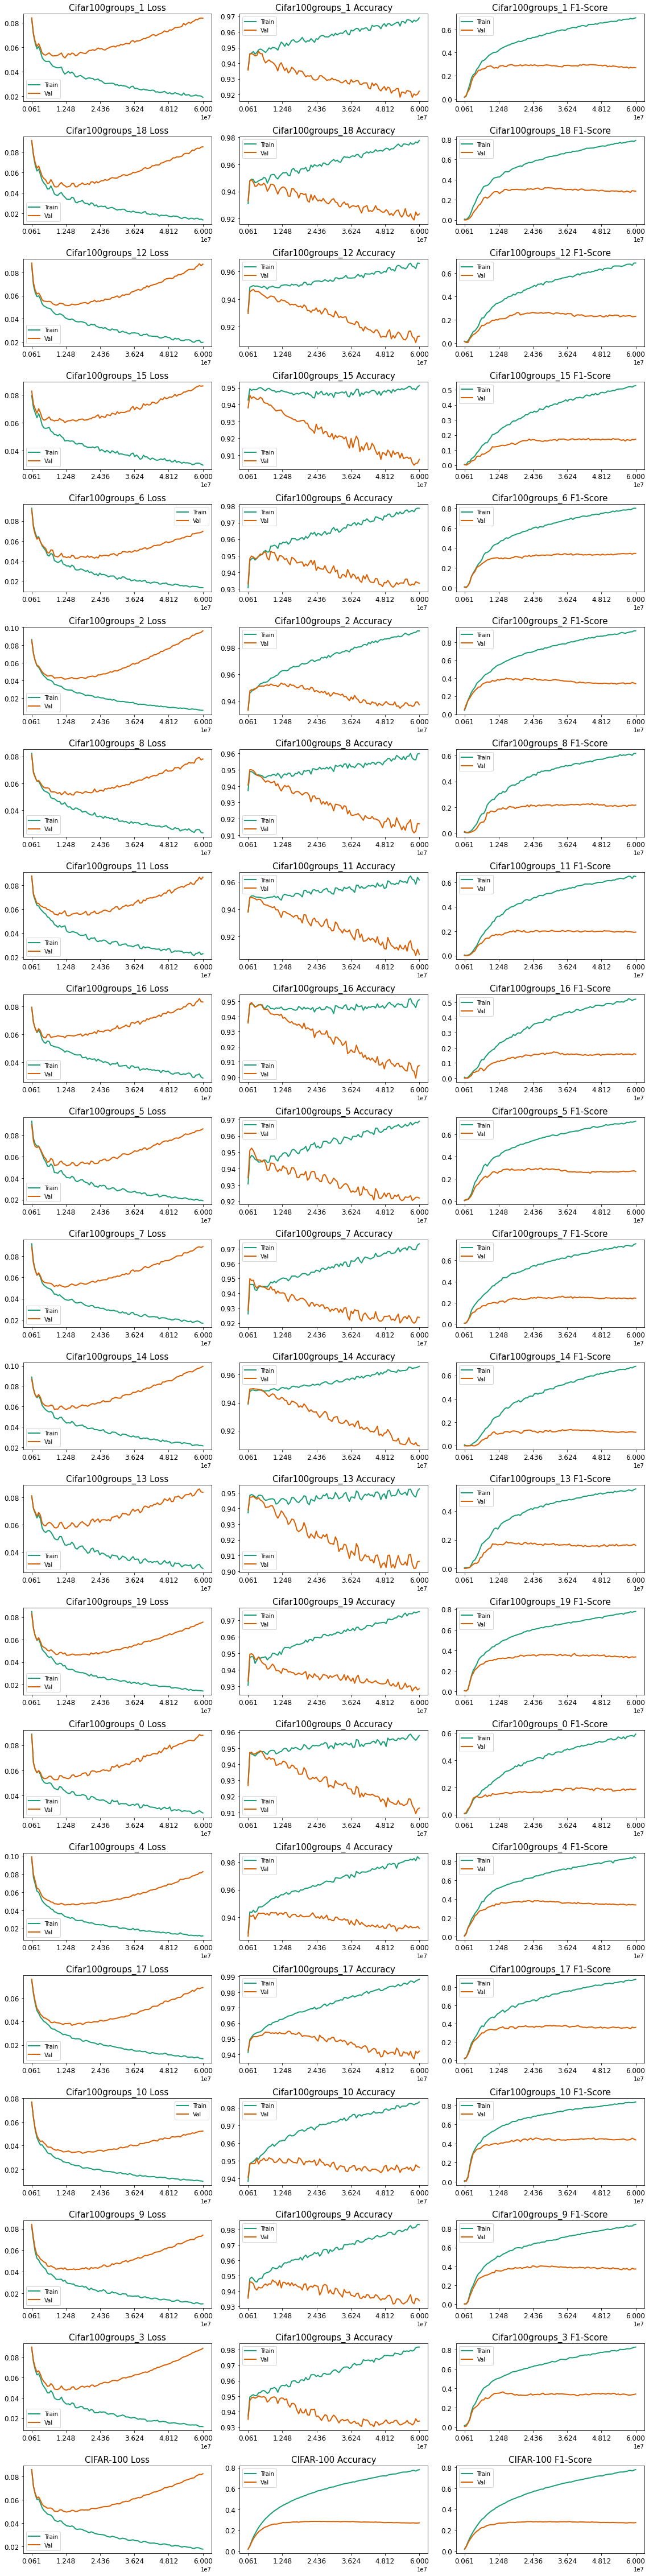

In [6]:
# Diverse options
plot_titles = True
plot_axis_labels = False

linewidth = 2

legend_loc = {
    'loss': 'upper right',
    'accuracy': 'lower right',
}

fontsizes = {
    'title': 15,
    'legend': 15,
    'ticks': 12,
}

color_palette = sns.color_palette('Dark2')

# Get the filter from the checkboxes
chosen_datasets = []
chosen_types = []
chosen_fe = []
chosen_metrics = []

for checkbox in datasets_checkboxes:
    if checkbox.value == True:
        chosen_datasets = chosen_datasets + [checkbox.description]
        
for checkbox in types_checkboxes:
    if checkbox.value == True:
        chosen_types = chosen_types + [checkbox.description]
        
for checkbox in fe_checkboxes:
    if checkbox.value == True:
        chosen_fe = chosen_fe + [checkbox.description]
        
for checkbox in metrics_checkboxes:
    if checkbox.value == True:
        chosen_metrics = chosen_metrics + [checkbox.description]
        
# Get other options
bootstrap = bootstrap_cb.value
plot_test = plot_test_cb.value
log_plot = log_plot_cb.value
plot_samples = plot_samples_cb.value
        

# Create figure
n_cols = len(chosen_metrics)
n_rows = len(chosen_datasets)
ratio_dim = 3
fig, axes = plt.subplots(
                nrows=n_rows,
                ncols=n_cols,
                figsize=(16 / ratio_dim * n_cols, 9 / ratio_dim * n_rows),
                squeeze=False
            )

# Get track of the position in the grid of subplots
pos = 0
go_to_next = False
        
# Create the plots
# For each datasets
for dset_name in chosen_datasets:
    dset_metrics_plot = metrics_plot[metrics_plot['dataset'] == dset_name]
    
    # For specialization and trained
    for type_name in chosen_types:
        type_plot = dset_metrics_plot[dset_metrics_plot['type'] == type_name]
        
        # For frozen and unfrozen feature extractor
        for fe in chosen_fe:
            fe_plot = type_plot[type_plot['feature_extractor'] == fe]

            # For all chosen metrics to display
            for idx, metric_name in enumerate(chosen_metrics):
                colors = itertools.cycle(color_palette)
                metric_name_plot = fe_plot[fe_plot['metric'] == metric_name]
                if metric_name_plot.empty:
                    pos += 1
                    continue
                    
                current_axis = axes[int(np.floor(pos / n_cols)), pos % n_cols]

                # For Split (train, validation and test)
                for split in pd.unique(metric_name_plot['split']):
                    split_plot = metric_name_plot[metric_name_plot['split'] == split]
                    if split == 'test' and not plot_test: break
                    if metric_name == 'overfitting' and split != 'train': continue

                    # Ignore best value for test
                    split_plot = split_plot[split_plot['epoch'] != -1]
                    # Actual values that will be plotted
                    split_values = pd.DataFrame(columns=split_plot.columns)
                    
                    # Take only the highest n_samples (to remove within epoch values due to ultra typhon)
                    for temp_epoch in pd.unique(split_plot['epoch']):
                        # Take only the epoch
                        split_epoch = split_plot[split_plot['epoch'] == temp_epoch]
                        split_epoch = split_epoch[split_epoch['n_samples'] == split_epoch['n_samples'].max()]
                        # Keep all other epochs
                        split_values = pd.concat([split_values, split_epoch])
                    
                    # Could filter points depending on the value here
                    points = [point if point <= 1 else point for point in split_values['value']]
                    
                    if plot_samples:
                        x_values = split_values['n_samples'].to_numpy()
                    else:
                        x_values = split_values['epoch'].to_numpy()
                        
                    # Go to next plot if there are NaN
                    if np.isnan(points).any():
                        go_to_next = True
                        break
                        
                    if not bootstrap:
                        x_values = x_values[1:]
                        points = points[1:]

                    # Actually plot the points
                    sns.lineplot(
                        x=x_values,
                        y=points,
                        linewidth=linewidth,
                        ax=current_axis,
                        color=next(colors),
                        label=pretty_print[split] if metric_name != 'overfitting' else '',
                    )
                  
                # If there are NaN go to next plot
                if go_to_next:
                    go_to_next = False
                    pos += 1
                    continue

                # Add title of the plot
                if plot_titles:
                    if type_plot['epoch'].empty: continue
                    number_epoch = max(type_plot['epoch'])
                    try:
                        pretty_ds_name = pretty_print[dset_name]
                    except KeyError:
                        pretty_ds_name = dset_name
                    title_plot = f"{pretty_ds_name} {pretty_print[metric_name]}"
                    current_axis.set_title(title_plot, fontsize=fontsizes['title'])
                
                # Axis labels
                if plot_axis_labels:
                    if plot_samples:
                        x_label = 'Samples'
                    else:
                        x_label = 'Epochs'
                    current_axis.set_xlabel(x_label, fontsize=fontsizes['ticks'])
                    current_axis.set_ylabel(pretty_print[metric_name], fontsize=fontsizes['ticks'])
                
                # Log plot or not
                if log_plot and metric_name == 'loss':
                    current_axis.set_yscale('log')

                # Generate the x-ticks
                x_ticks = np.linspace(x_values[0], x_values[-1], 6, dtype=np.dtype(int))
                current_axis.set_xticks(x_ticks)
                current_axis.tick_params(labelsize=fontsizes['ticks'])
                
                # Generate the y-ticks
                # Fixed range for metrics other than loss, only for the heads
#                 if metric_name != 'loss' and '_' in dset_name:
#                 if metric_name != 'loss':
#                     current_axis.set_ylim([0.58, 1.02])
#                 if metric_name == 'loss' and '_' in dset_name:
#                 if metric_name == 'loss':
#                     current_axis.set_yticks(np.linspace(0, 0.16, 6))
#                     current_axis.set_ylim([-0.01, 0.17])
                
                pos += 1
                
                
# Automatic padding between plots
fig.tight_layout()
plt.savefig(path / f"{exp_radiobuttons.value}_metrics.pdf")
plt.show()

### Graphs within an epoch (Ultra Typhon)

In [12]:
epochs_available = list(pd.unique(metrics_plot['epoch']))
epochs_available.remove(-1)
epochs_available.remove(0)

epoch_to_display = widgets.Dropdown(
    options=epochs_available,
    description='Epoch:',
)
display(epoch_to_display)

Dropdown(description='Epoch:', options=(215517, 431034, 646551, 862068, 1077586, 1219200), value=215517)

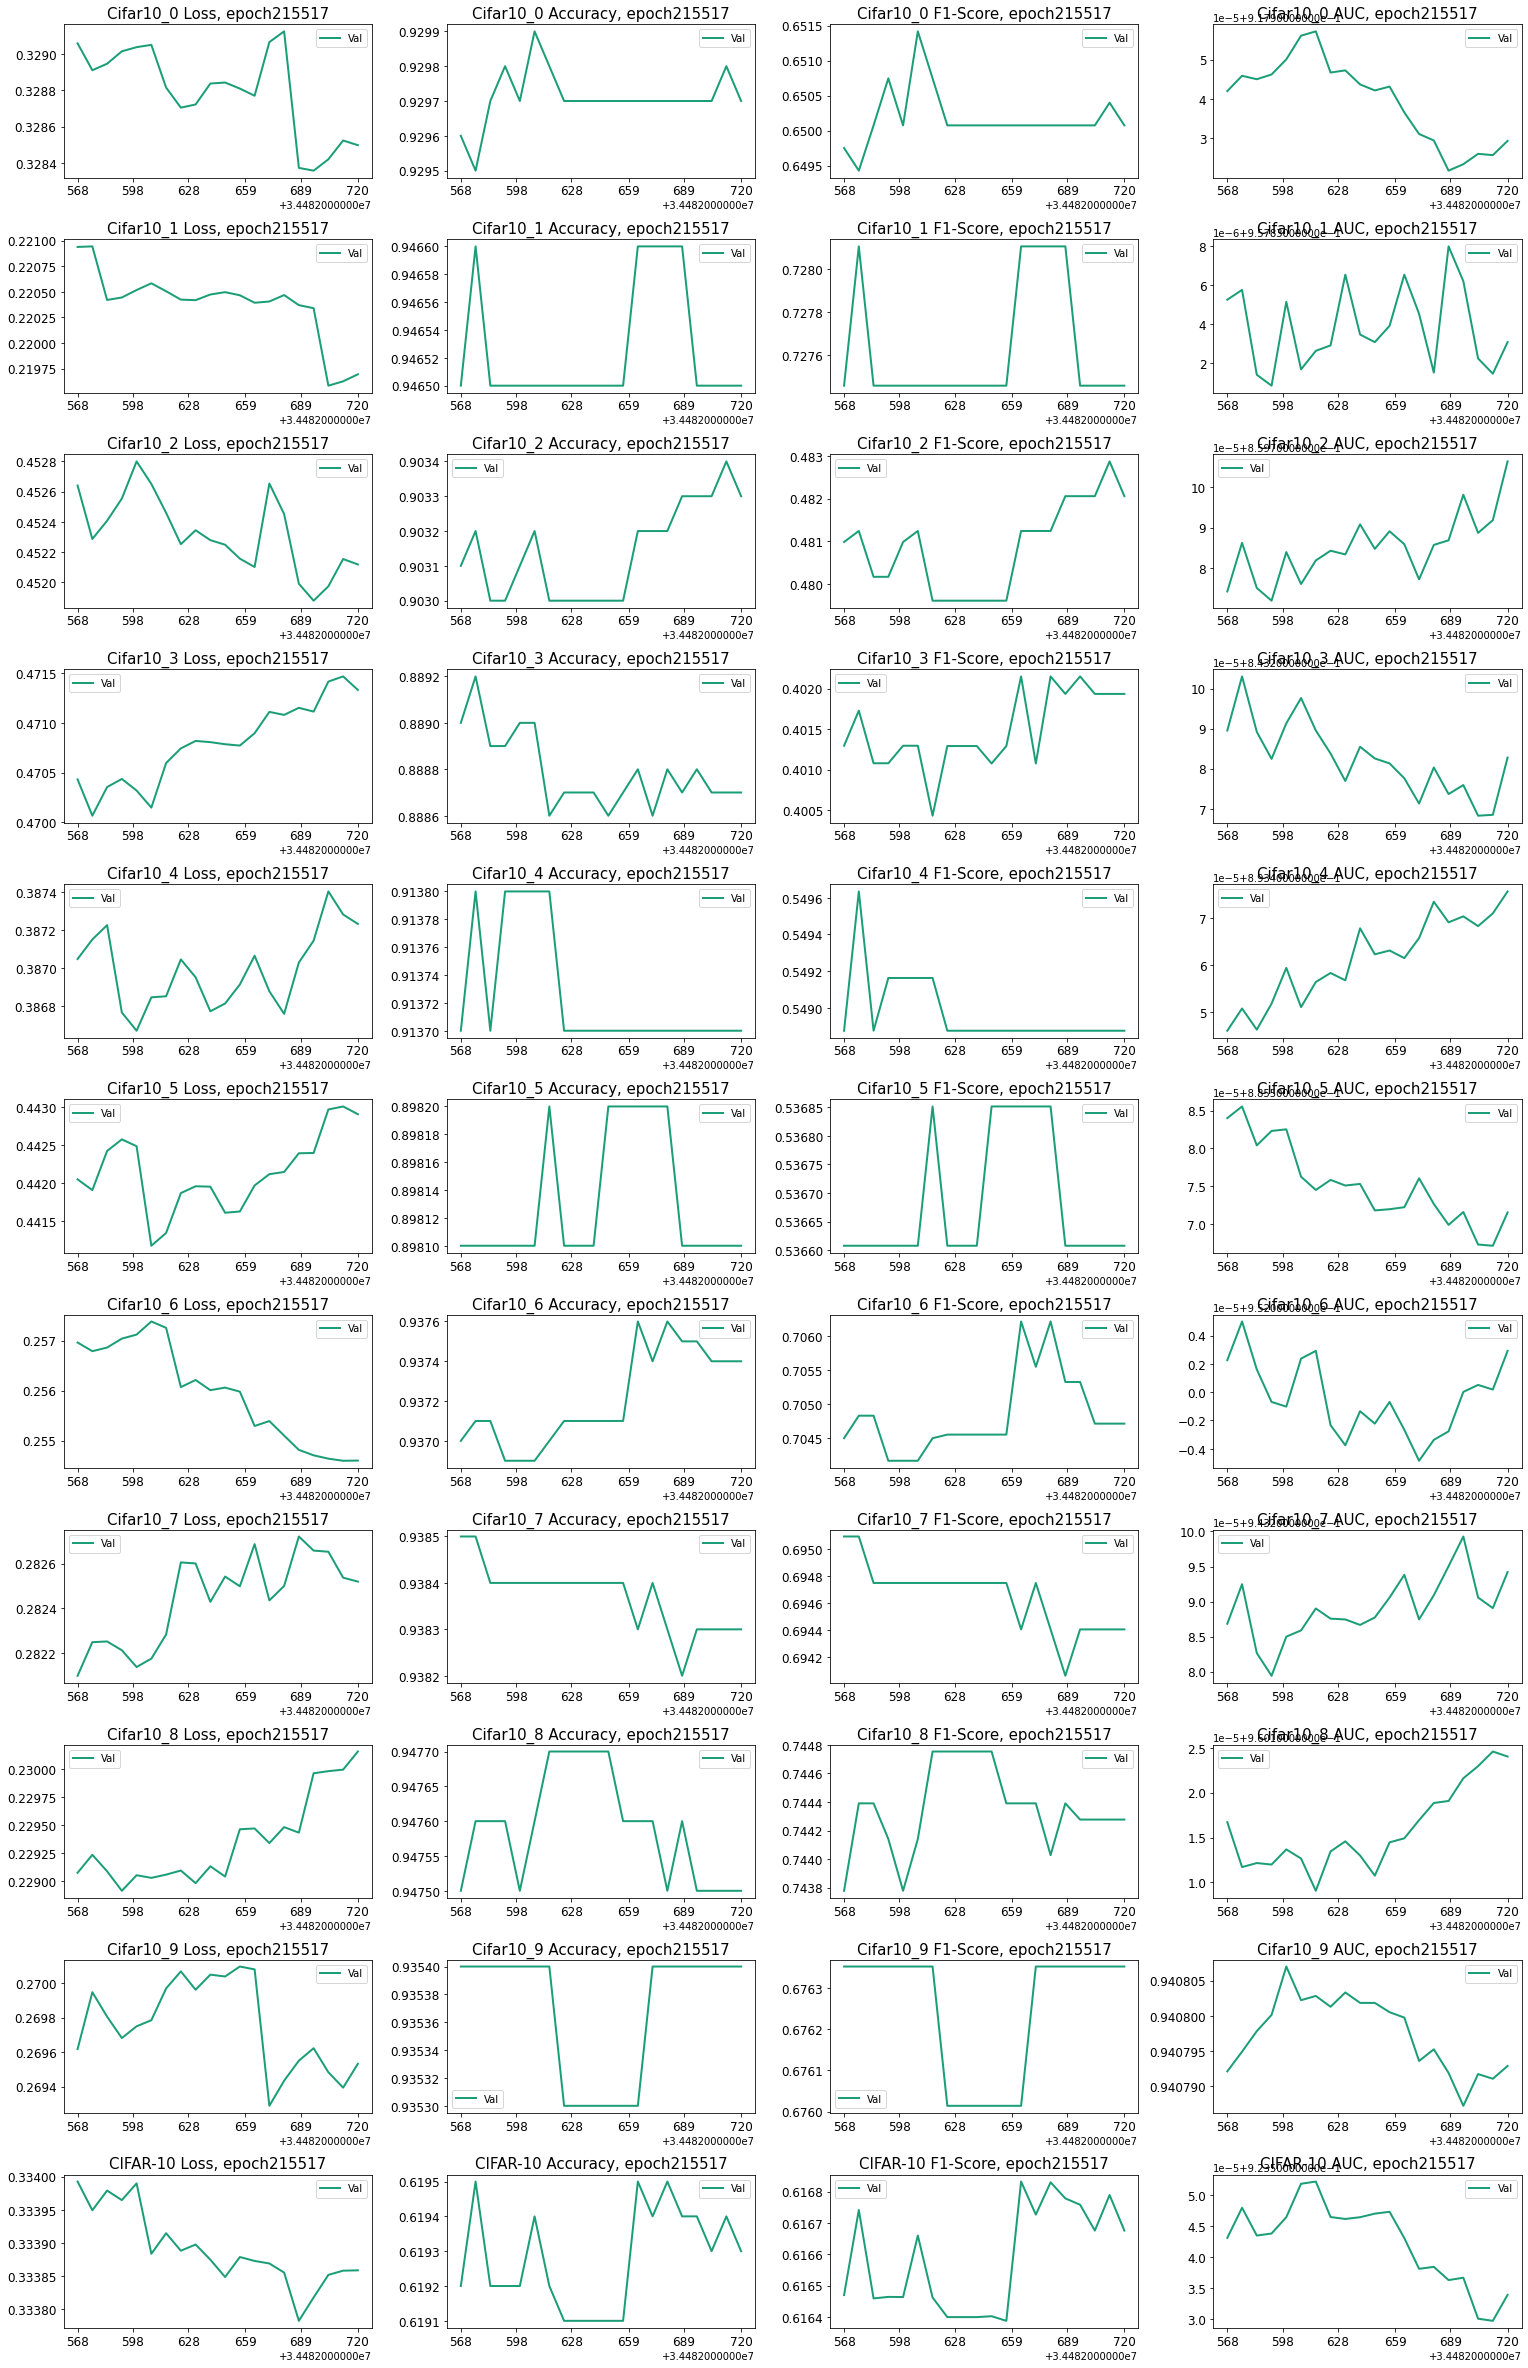

In [13]:
# Diverse options
plot_titles = True
plot_axis_labels = False

linewidth = 2

legend_loc = {
    'loss': 'upper right',
    'accuracy': 'lower right',
}

fontsizes = {
    'title': 15,
    'legend': 15,
    'ticks': 12,
}

color_palette = sns.color_palette('Dark2')

# Get the filter from the checkboxes
chosen_datasets = []
chosen_types = []
chosen_fe = []
chosen_metrics = []

for checkbox in datasets_checkboxes:
    if checkbox.value == True:
        chosen_datasets = chosen_datasets + [checkbox.description]
        
for checkbox in types_checkboxes:
    if checkbox.value == True:
        chosen_types = chosen_types + [checkbox.description]
        
for checkbox in fe_checkboxes:
    if checkbox.value == True:
        chosen_fe = chosen_fe + [checkbox.description]
        
for checkbox in metrics_checkboxes:
    if checkbox.value == True:
        chosen_metrics = chosen_metrics + [checkbox.description]
        
# Get other options
wanted_epoch = epoch_to_display.value

# Create figure
n_cols = len(chosen_metrics)
n_rows = len(chosen_datasets)
ratio_dim = 3
fig, axes = plt.subplots(
                nrows=n_rows,
                ncols=n_cols,
                figsize=(16 / ratio_dim * n_cols, 9 / ratio_dim * n_rows),
                squeeze=False
            )

# Get track of the position in the grid of subplots
pos = 0
go_to_next = False
        
# Create the plots
# For each datasets
for dset_name in chosen_datasets:
    dset_metrics_plot = metrics_plot[metrics_plot['dataset'] == dset_name]
    
    # For specialization and trained
    for type_name in chosen_types:
        type_plot = dset_metrics_plot[dset_metrics_plot['type'] == type_name]
        
        # For frozen and unfrozen feature extractor
        for fe in chosen_fe:
            fe_plot = type_plot[type_plot['feature_extractor'] == fe]

            # For all chosen metrics to display
            for idx, metric_name in enumerate(chosen_metrics):
                colors = itertools.cycle(color_palette)
                metric_name_plot = fe_plot[fe_plot['metric'] == metric_name]
#                 if metric_name != 'loss': continue
                if metric_name_plot.empty:
                    pos += 1
                    continue
                    
                current_axis = axes[int(np.floor(pos / n_cols)), pos % n_cols]
   
                # For Split (train, validation and test)
                for split in pd.unique(metric_name_plot['split']):
                    split_plot = metric_name_plot[metric_name_plot['split'] == split]
                    if split == 'test' and not plot_test: break
                        
                        
                    if split == 'train': continue
                        
                        
                    split_values = split_plot[split_plot['epoch'] == wanted_epoch]
          
                    # Could filter points depending on the value here
                    points = [point if point <= 1 else point for point in split_values['value']]
                    x_values = split_values['n_samples'].to_numpy()
                        
                    # Go to next plot if there are NaN
                    if np.isnan(points).any():
                        go_to_next = True
                        break

                    # Actually plot the points
                    sns.lineplot(
                        x=x_values,
                        y=points,
                        linewidth=linewidth,
                        ax=current_axis,
                        label=pretty_print[split],
                        color=next(colors),
                    )
        
                # If there are NaN go to next plot
                if go_to_next:
                    go_to_next = False
                    pos += 1
                    continue

                # Add title of the plot
                if plot_titles:
                    if type_plot['epoch'].empty: continue
                    number_epoch = max(type_plot['epoch'])
                    try:
                        pretty_ds_name = pretty_print[dset_name]
                    except KeyError:
                        pretty_ds_name = dset_name
                    title_plot = f"{pretty_ds_name} {pretty_print[metric_name]}, epoch{wanted_epoch}"
                    current_axis.set_title(title_plot, fontsize=fontsizes['title'])
                
                # Axis labels
                if plot_axis_labels:
                    if plot_samples:
                        x_label = 'Samples'
                    else:
                        x_label = 'Epochs'
                    current_axis.set_xlabel(x_label, fontsize=fontsizes['ticks'])
                    current_axis.set_ylabel(pretty_print[metric_name], fontsize=fontsizes['ticks'])
                
                # Log plot or not
                if log_plot and metric_name == 'loss':
                    current_axis.set_yscale('log')

                # Generate the x-ticks
                x_ticks = np.linspace(x_values[0], x_values[-1], 6, dtype=np.dtype(int))
                current_axis.set_xticks(x_ticks)
                current_axis.tick_params(labelsize=fontsizes['ticks'])
                
                # Generate the y-ticks
                # Fixed range for metrics other than loss, only for the heads
#                 if metric_name != 'loss' and '_' in dset_name:
#                 if metric_name != 'loss':
#                     current_axis.set_ylim([0.58, 1.02])
#                 if metric_name == 'loss' and '_' in dset_name:
#                 if metric_name == 'loss':
#                     current_axis.set_yticks(np.linspace(1, 1.3, 4))
#                     current_axis.set_ylim([0.98, 1.32])
                
                pos += 1
                
                
# Automatic padding between plots
fig.tight_layout()
plt.savefig(path / f"{exp_radiobuttons.value}_within_epoch_{wanted_epoch}.pdf")
plt.show()

### Plot metrics of each head/datasets on the same graph

ValueError: x and y must have same first dimension, but have shapes (98,) and (99,)

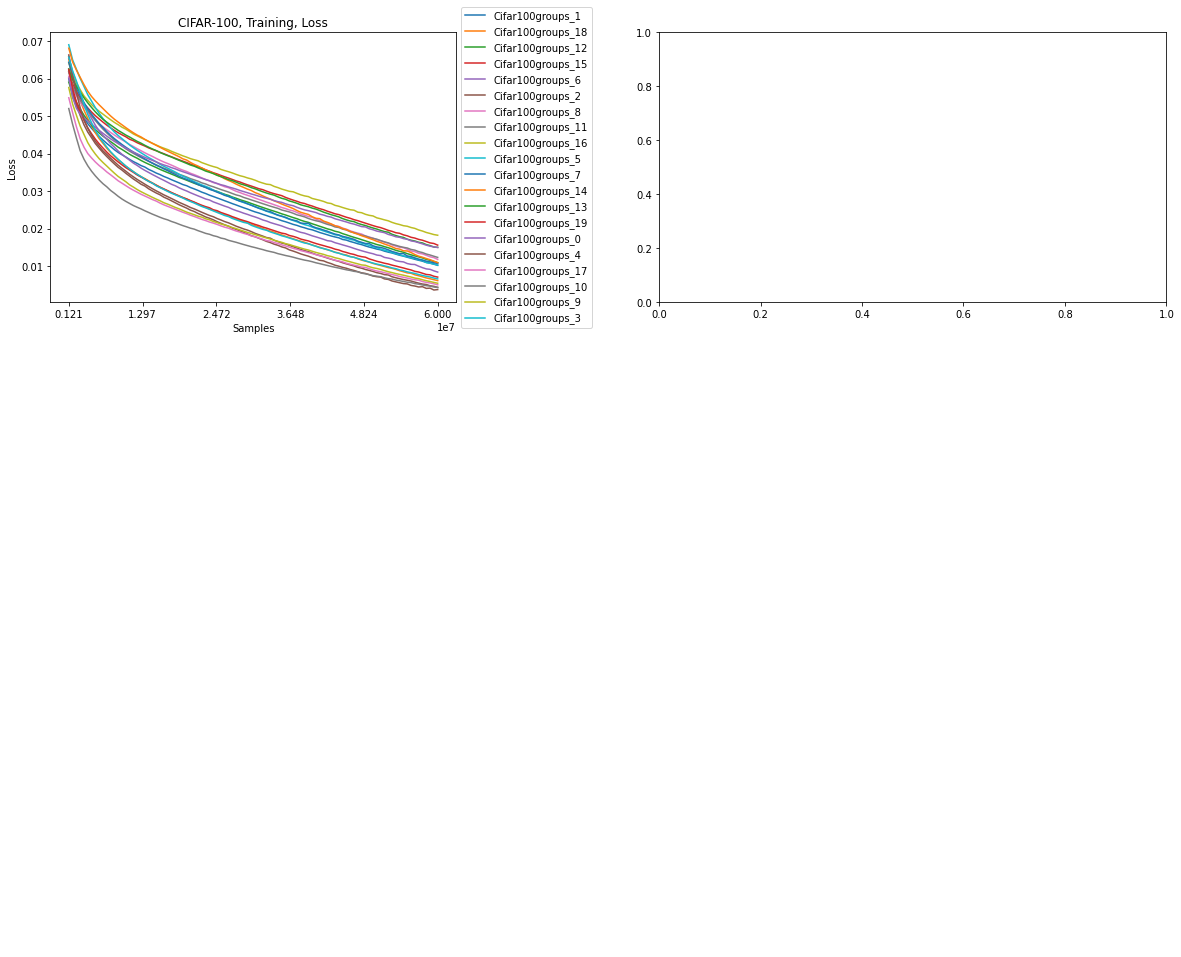

In [43]:
# Sometime big decrease in first 2/3 values makes y-axis big, and can't really see later changement
#  In these cases, start the plot from the 2nd/3rd value
# START_EPOCH = 0
# STOP_EPOCH = 100000

# Whether to save all subplots individually
save_all = False
single_plots = []

# Whether to add the titles to the single subplots
plot_titles = True
plot_legend = True

# List or horizontal lines in form of (y_val, color, style, label)
# Only for the single subplots
h_lines = [
#     (0.5, 'red', 'dotted', 'random1'),
#     (0.7, 'green', 'solid', '')
]

linewidth = 8

# legend_fontsize = 18
legend_loc = {
    'loss': 'upper right',
    'accuracy': 'lower right',
}

fontsizes = {
    'legend': 50,
    'axis': 60,
    'ticks': 50,
    'title': 70
}

# Get the filter from the checkboxes
chosen_datasets = []
chosen_types = []
chosen_fe = []
chosen_metrics = []

for checkbox in datasets_checkboxes:
    if checkbox.value == True:
        chosen_datasets = chosen_datasets + [checkbox.description]
        
for checkbox in types_checkboxes:
    if checkbox.value == True:
        chosen_types = chosen_types + [checkbox.description]
        
for checkbox in fe_checkboxes:
    if checkbox.value == True:
        chosen_fe = chosen_fe + [checkbox.description]
        
for checkbox in metrics_checkboxes:
    if checkbox.value == True:
        chosen_metrics = chosen_metrics + [checkbox.description]
        
# Get other options
bootstrap = bootstrap_cb.value
plot_test = plot_test_cb.value
log_plot = log_plot_cb.value
plot_samples = plot_samples_cb.value
        

# Create figure
nplots = len(chosen_types)*len(chosen_fe)*len(chosen_metrics)*2
fig, axes = plt.subplots(int(np.ceil(nplots / 2)), 2, figsize=(20,5.625*(nplots/2)), squeeze=False)

# Enable axes while plotting
for row in axes:
    for axis in row:
        axis.set_axis_off()
pos = 0
        
all_points = {}
    
# For specialization and trained
for type_name in chosen_types:
    type_plot = metrics_plot[metrics_plot['type'] == type_name]

    # For frozen and unfrozen feature extractor
    for fe in chosen_fe:
        fe_plot = type_plot[type_plot['feature_extractor'] == fe]

        # Plots valset and trainset performance
        for idx, metric_name in enumerate(chosen_metrics):
            metric_name_plot = fe_plot[fe_plot['metric'] == metric_name]
            if metric_name_plot.empty: continue
            legends = []
            metric_all_points = None
            # Display the axes
            axes[int(np.floor(pos / 2)), pos % 2].set_axis_on()

            if save_all: n_fig, n_axs = plt.subplots(figsize=(16, 9))

            # For Split (train, validation and test)
            for dset_name in chosen_datasets:
                if '_' not in dset_name: continue 
                dset_metrics_plot = metric_name_plot[metric_name_plot['dataset'] == dset_name]
                split_plot = dset_metrics_plot[dset_metrics_plot['split'] == 'train']
#                 if split == 'test' and not plot_test: break
#                 if split == "validation": continue

                # Ignore best value for test
                split_plot = split_plot[split_plot['epoch'] != -1]
                points = [point if point <= 1 else point for point in split_plot['value']]

                if plot_samples:
                    x_values = split_plot['n_samples']
                else:
                    x_values = split_plot['epoch']

                x_values = x_values[1:]
                points = points[1:]
                
                if metric_all_points is None:
                    metric_all_points = np.array([points])
                else:
                    metric_all_points = np.vstack((metric_all_points, [points]))

                if not bootstrap and split_plot['epoch'].iloc[0] == 0:
                    x_values = x_values[1:]
                    points = points[1:]

                axes[int(np.floor(pos / 2)), pos % 2].plot(x_values, points)
                legends.append(dset_name)

                if save_all: n_axs.plot(split_plot['epoch'], points, linewidth=linewidth)

            if save_all:
                # Possibly add title
                title = f"{pretty_print[dset_name]}, {pretty_print[metric_name]}"
                if plot_titles: n_axs.set_title(title, fontsize=fontsizes['title'])
                # Possibly add horizontal line(s)
                for y, c, s, l in h_lines:
                    n_axs.axhline(y=y, color=c, linestyle=s, label=l)
                    legends.append(l)
                # Add axes labels
                n_axs.set_xlabel('Epochs (x 1\'000)', fontsize=fontsizes['axis'])
                n_axs.set_ylabel(pretty_print[metric_name], fontsize=fontsizes['axis'])
                plt.yticks(fontsize=fontsizes['ticks'])
                plt.xticks(fontsize=fontsizes['ticks'])
                # Add legend
                if plot_legend:n_axs.legend(legends, loc=legend_loc, fontsize=fontsizes['legend'])#, bbox_to_anchor=(1.0, 1.05))
                n_fig.tight_layout()
                single_plots.append((n_fig, title))
                plt.close(n_fig)


            # Add legend, title and axes name
            if type_plot['epoch'].empty: continue
            number_epoch = max(type_plot['epoch'])
            try:
                loc = legend_loc[metric_name]
            except KeyError:
                loc = 'lower right'
                
            # Shrink current axis by 20%
            box = axes[int(np.floor(pos / 2)), pos % 2].get_position()
            axes[int(np.floor(pos / 2)), pos % 2].set_position([box.x0, box.y0, box.width * 0.8, box.height])

            # Put a legend to the right of the current axis
            axes[int(np.floor(pos / 2)), pos % 2].legend(legends, loc='center left', bbox_to_anchor=(1, 0.5))
            
            try:
                pretty_ds_name = pretty_print[dset_name]
            except KeyError:
                pretty_ds_name = dset_name

            axes[int(np.floor(pos / 2)), pos % 2].set_title(f"{pretty_ds_name}, {pretty_print[type_name]}, {pretty_print[metric_name]}")

            # Labels
            if plot_samples:
                x_label = 'Samples'
            else:
                x_label = 'Epochs'
            axes[int(np.floor(pos / 2)), pos % 2].set_xlabel(x_label)
            axes[int(np.floor(pos / 2)), pos % 2].set_ylabel(pretty_print[metric_name])

            # Log plot or not
            if log_plot and metric_name == 'loss':
                axes[int(np.floor(pos / 2)), pos % 2].set_yscale('log')

            # Generate the x-ticks
            x_ticks = np.linspace(x_values.iloc[0], x_values.iloc[-1], 6, dtype=np.dtype(int))
            axes[int(np.floor(pos / 2)), pos % 2].set_xticks(x_ticks)

            pos += 1
            
            # Plot the avergae of the metrix
            avg_points = np.mean(metric_all_points, axis=0)
            axes[int(np.floor(pos / 2)), pos % 2].set_axis_on()
            axes[int(np.floor(pos / 2)), pos % 2].plot(x_values, avg_points)
            axes[int(np.floor(pos / 2)), pos % 2].set_xlabel(x_label)
            axes[int(np.floor(pos / 2)), pos % 2].set_ylabel(pretty_print[metric_name])
            axes[int(np.floor(pos / 2)), pos % 2].set_title(f"{pretty_ds_name}, {pretty_print[type_name]}, average {pretty_print[metric_name]}")
            # Log plot or not
            if log_plot and metric_name == 'loss':
                axes[int(np.floor(pos / 2)), pos % 2].set_yscale('log')
            
            
            pos += 1
                
                
# Automatic padding between plots
# fig.tight_layout()
plt.savefig(path / f"reference_sheet_{exp_radiobuttons.value}.pdf")
plt.show()

---

### Plot metrics of combinations (classic, classic-do, Typhon, Typhon-do) on test set

In [7]:
bootstrap_cb = widgets.Checkbox(value=False, description="Bootstrap")
plot_test_cb = widgets.Checkbox(value=False, description="Plot test set")
log_plot_cb = widgets.Checkbox(value=False, description="Log plot on loss")
plot_samples_cb = widgets.Checkbox(value=True, description="Plot samples")

vbox = [bootstrap_cb, plot_test_cb, log_plot_cb, plot_samples_cb]
output = widgets.VBox(children=vbox)

display(output)

/home/chris/Desktop/results/10heads_5
/home/chris/Desktop/results/maxbs256_3
/home/chris/Desktop/results/15heads_4
/home/chris/Desktop/results/5heads_6


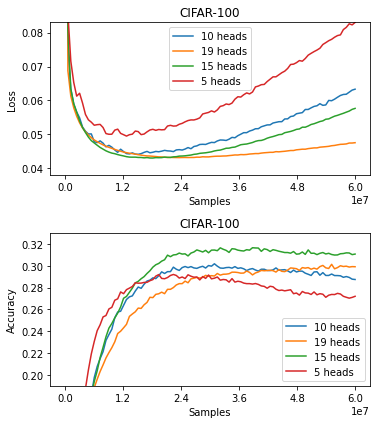

In [22]:
import copy

list_points = {}
x_val = {}
root_path = Path('/home/chris/Desktop/results')
bootstrap = bootstrap_cb.value
plot_test = plot_test_cb.value
log_plot = log_plot_cb.value
plot_samples = plot_samples_cb.value
# nplots = 0

legend_loc = {
    'loss': 'upper center',
    'accuracy': 'lower right',
}


open_path = list(root_path.iterdir())[0] / 'run_plot' / 'metrics.csv'
metrics = pd.read_csv(open_path)
for dset_name in pd.unique(metrics['dataset']):
    if dset_name == 'Cifar100groups': dset_name = 'Cifar100'
    list_points[dset_name] = {}
    x_val[dset_name] = {}
    for metric_name in pd.unique(metrics['metric']):
        list_points[dset_name][metric_name] = []
        x_val[dset_name][metric_name] = []
        
# nplots = len(pd.unique(metrics['dataset']))*len(pd.unique(metrics['metric']))
nplots = len(pd.unique(metrics['dataset']))*2
# nplots = len(pd.unique(metrics['metric']))
        

for combination_path in root_path.iterdir():
    path = combination_path / 'run_plot'
    metrics_plot = pd.read_csv(path / 'metrics.csv')
    copy_data = copy.deepcopy(metrics_plot)
    print(combination_path)

    # Create the plots
    for dset_name in pd.unique(copy_data['dataset']):
        if '_' in dset_name: continue
        dset_metrics_plot = metrics_plot[metrics_plot['dataset'] == dset_name]

        # Plots valset and trainset performance
        for idx, metric_name in enumerate(pd.unique(copy_data['metric'])):
            if metric_name not in ['loss', 'accuracy']: continue
            metric_name_plot = dset_metrics_plot[dset_metrics_plot['metric'] == metric_name]
            if metric_name_plot.empty: continue

            split_plot = metric_name_plot[metric_name_plot['split'] == 'test']
#             split_plot = metric_name_plot[metric_name_plot['split'] == 'train']

            # Ignore best value for test
            split_plot = split_plot[split_plot['epoch'] != -1]
#             points = [point if point <= 1 else point for point in split_plot['value']]

            if plot_samples:
#                 x_values = split_plot['n_samples']
                x_values = split_plot[split_plot['n_samples'] <= 6e7]['n_samples']
            else:
                x_values = split_plot['epoch']
                
            points = [split_plot['value'].iloc[i] for i in range(len(x_values))]
                
                
                
#             x_values = x_values * 2
#             try:
#                 x_values = split_plot['n_samples']
#             except KeyError:
#                 x_values = split_plot['epoch'] * 8
                
                

#             x_values = x_values[2:]
#             points = points[2:]

            # If bootstrap false, do not display it for the training
            if not bootstrap and split_plot['epoch'].iloc[0] == 0:
                x_values = x_values[1:]
                points = points[1:]

            if dset_name == 'Cifar100groups': dset_name = 'Cifar100'
            list_points[dset_name][metric_name].append(points)
            x_val[dset_name][metric_name].append(x_values)
                
#             nplots += 1
    
# Create figure
n_cols = 1
n_rows = 2
ratio_dim = 3
fig, axes = plt.subplots(
                nrows=n_rows,
                ncols=n_cols,
                figsize=(16 / ratio_dim * n_cols, 9 / ratio_dim * n_rows),
                squeeze=False
            )

# Enable axes while plotting
for row in axes:
    for axis in row:
        axis.set_axis_off()
    
pos = 0

for dset_name, dset_metrics in list_points.items():
    if '_' in dset_name: continue
    for metric_name, super_list_points in dset_metrics.items():
        colors = itertools.cycle(sns.color_palette('tab10'))
        if metric_name not in ["loss", "accuracy"]: continue
        axes[int(np.floor(pos / n_cols)), pos % n_cols].set_axis_on()
        for x_values, points in zip(x_val[dset_name][metric_name], super_list_points):
            # Plot
            axes[int(np.floor(pos / n_cols)), pos % n_cols].plot(x_values, points, color=next(colors))
            
        try:
            loc = legend_loc[metric_name]
        except KeyError:
            loc = 'lower right'
            
        # TODO: Change legend manually!
        # CIFAR-100
        axes[int(np.floor(pos / n_cols)), pos % n_cols].legend(["Caffe", "Caffe_v3", "Caffe_v4", "Caffe_v2", "Classic"], loc=loc)
        # CIFAR-10
#         axes[int(np.floor(pos / n_cols)), pos % n_cols].legend(["Classic", "Caffe_v2", "Caffe_v3", "Caffe", 'Caffe_v4'], loc=loc)
        axes[int(np.floor(pos / n_cols)), pos % n_cols].legend(["10 heads", "19 heads", "15 heads", "5 heads"], loc=loc)
        try:
            pretty_ds_name = pretty_print[dset_name]
        except KeyError:
            pretty_ds_name = dset_name

        axes[int(np.floor(pos / n_cols)), pos % n_cols].set_title(f"{pretty_ds_name}")

        # Labels
        if plot_samples:
            x_label = 'Samples'
        else:
            x_label = 'Epochs'
        axes[int(np.floor(pos / n_cols)), pos % n_cols].set_xlabel(x_label)
        axes[int(np.floor(pos / n_cols)), pos % n_cols].set_ylabel(pretty_print[metric_name])

        # Log plot or not
        if log_plot and metric_name == 'loss':
            axes[int(np.floor(pos / n_cols)), pos % n_cols].set_yscale('log')

        # Generate the x-ticks
        x_ticks = np.linspace(x_values.iloc[0], x_values.iloc[-1], 6, dtype=np.dtype(int))
        axes[int(np.floor(pos / n_cols)), pos % n_cols].set_xticks(x_ticks)
        
        # Generate the y-ticks
        if metric_name == 'loss':
#             CIFAR-100
            axes[int(np.floor(pos / n_cols)), pos % n_cols].set_yticks(np.linspace(0.04, 0.08, 5))
            axes[int(np.floor(pos / n_cols)), pos % n_cols].set_ylim([0.038, 0.083])
            # CIFAR-10
#             axes[int(np.floor(pos / n_cols)), pos % n_cols].set_yticks(np.linspace(0.16, 0.44, 8))
#             axes[int(np.floor(pos / n_cols)), pos % n_cols].set_ylim([0.15, 0.45])
        if metric_name == 'accuracy':
#             CIFAR-100
            axes[int(np.floor(pos / n_cols)), pos % n_cols].set_yticks(np.linspace(0.20, 0.32, 7))
            axes[int(np.floor(pos / n_cols)), pos % n_cols].set_ylim([0.19, 0.33])            
            # CIFAR-10
#             axes[int(np.floor(pos / n_cols)), pos % n_cols].set_yticks(np.linspace(0.53, 0.68, 6))
#             axes[int(np.floor(pos / n_cols)), pos % n_cols].set_ylim([0.52, 0.69])
        pos += 1



fig.tight_layout()
plt.savefig(f"/home/chris/Desktop/test_plot.pdf")
plt.show()
    

In [ ]:
# Save single subplots
# Require to manually create folder "Subplots" in "run_plots"
if save_all:
    import os
    if not os.path.exists(path / "Subplots"): os.mkdir(path / "Subplots")
    print(path/ "Subplots")
    for img, title in tqdm(single_plots):
        img.figure.savefig(path / f"Subplots/normal_nolegend_nok_UDIAT_Precision.pdf")
        img.figure.savefig(path / f"Subplots/{title}.pdf")

In [ ]:
bus_dices = metrics_plot.loc[((metrics_plot['dataset'] == 'UDIAT') & (metrics_plot['metric'] == 'dice') & (metrics_plot['split'] == 'validation'))]
bus_dices

print(len(bus_dices))
bus_dices.loc[bus_dices['value']==bus_dices['value'].max()]

In [ ]:
def add_labels(x,y):
    for i, xv in enumerate(x):
#         plt.text(xv, y[i] + 0.01, int(y[i] * 100), fontsize=17, ha='center')
        plt.text(xv, y[i] + 0.01, int(round(y[i] * 100)), fontsize=17, ha='center')
        
def add_metrics(x,txts):
    for i, xv in enumerate(x):
        t = plt.text(xv, - 0.06, txts[i], fontsize=25, ha='center')
        t.set_bbox(dict(facecolor='aqua', alpha=0.9, edgecolor='black'))

for dset_name in chosen_datasets:
    dset_metrics_plot = metrics_plot[metrics_plot['dataset'] == dset_name]
    
    # For specialization and trained
    for type_name in chosen_types:
        type_plot = dset_metrics_plot[dset_metrics_plot['type'] == type_name]
        
        # For frozen and unfrozen feature extractor
        for fe in chosen_fe:
            fe_plot = type_plot[type_plot['feature_extractor'] == fe]

            metrics_values = {s:[] for s in pd.unique(metric_name_plot['split'])}
            
            # Hardcode metrics order to match paper
            chosen_metrics_hardcoded = ['f1score', 'iou', 'specificity', 'precision', 'recall', 'dice'] #, 'auc']
            chosen_metrics = chosen_metrics_hardcoded
            
            # Get metrics scores
            for idx, metric_name in enumerate(chosen_metrics):
                metric_name_plot = fe_plot[fe_plot['metric'] == metric_name]
                
                # For Split (train, validation and test)
                for split in pd.unique(metric_name_plot['split']):
                    split_plot = metric_name_plot[metric_name_plot['split'] == split]
                    if split == 'test':
                        split_plot = split_plot[split_plot['epoch'] == -1]
                        # Get value
                        metrics_values[split].append(split_plot['value'].values[0])
#                         metrics_values[split].append(split_plot['value'])
                    else:
                        # Get last index
                        metrics_values[split].append(split_plot['value'].iat[-1])
                        
                        
            colors = {
                'train': 'blue',
                'validation': 'green',
                'test': 'red',
                'paper': 'black'
            }
#             metrics_values['paper'] = [0, 0.7924, 0, 0.884, 0.8822, 0.8691]
            metrics_values['paper'] = [0, 0.7309, 0, 0.7861, 0.9007, 0.8179] # dset b
            # JI == IoU (or not?)
            
            width = 0.2
            plt.figure(figsize=(18,10))
            plt.xticks([], []) # Remove x-ticks
            plt.yticks(fontsize=17) # Change font size of y-ticks
            plt.bar(np.arange(len(metrics_values['train'])), metrics_values['train'], width=.9*width, label='train', color=colors['train'])
            add_labels(np.arange(len(metrics_values['train'])), metrics_values['train'])
            plt.bar(np.arange(len(metrics_values['validation'])) + width, metrics_values['validation'], width=.9*width, label='validation', color=colors['validation'])
            add_labels(np.arange(len(metrics_values['validation'])) + width, metrics_values['validation'])
            add_metrics(np.arange(len(metrics_values['validation'])) + width, chosen_metrics)
            try:
                plt.bar(np.arange(len(metrics_values['test'])) + 2*width, metrics_values['test'], width=.9*width, label='test', color=colors['test'])
                add_labels(np.arange(len(metrics_values['test'])) + 2*width, metrics_values['test'])
            except: 
                print('Test metrics not yet computed, wait for end of the training')
            plt.bar(np.arange(len(metrics_values['paper'])) + 3*width, metrics_values['paper'], width=.9*width, label='paper', color=colors['paper'])
            add_labels(np.arange(len(metrics_values['paper'])) + 3*width, metrics_values['paper'])
            
            plt.title(pretty_dset_name(dset_name) + ' - ' + exp_radiobuttons.value, fontsize=30)
            plt.legend(fontsize=20, bbox_to_anchor=(.96, 1.05))
            
            plt.savefig(path / f"{exp_radiobuttons.value}_{pretty_dset_name(dset_name)}_hist.png")
            plt.show()

In [ ]:
MAX_EPOCHS = 100000

def add_labels(x,y):
    for i, xv in enumerate(x):
#         plt.text(xv, y[i] + 0.01, int(y[i] * 100), fontsize=17, ha='center')
        plt.text(xv, y[i] + 0.01, int(round(y[i] * 100)), fontsize=17, ha='center')
        
def add_metrics(x,txts):
    for i, xv in enumerate(x):
        t = plt.text(xv, - 0.06, txts[i], fontsize=25, ha='center')
        t.set_bbox(dict(facecolor='aqua', alpha=0.9, edgecolor='black'))

for dset_name in chosen_datasets:
    dset_metrics_plot = metrics_plot[metrics_plot['dataset'] == dset_name]
    
    # For specialization and trained
    for type_name in chosen_types:
        type_plot = dset_metrics_plot[dset_metrics_plot['type'] == type_name]
        
        # For frozen and unfrozen feature extractor
        for fe in chosen_fe:
            fe_plot = type_plot[type_plot['feature_extractor'] == fe]

            metrics_values = {s:[] for s in pd.unique(metric_name_plot['split'])}
            
            # Hardcode metrics order to match paper
            chosen_metrics_hardcoded = ['f1score', 'iou', 'specificity', 'precision', 'recall', 'dice'] #, 'auc']
            chosen_metrics = chosen_metrics_hardcoded
            
            # Get metrics scores
            for idx, metric_name in enumerate(chosen_metrics):
                metric_name_plot = fe_plot[fe_plot['metric'] == metric_name]
                
                
                # For Split (train, validation and test)
                for split in pd.unique(metric_name_plot['split']):
                    split_plot = metric_name_plot[metric_name_plot['split'] == split]
                    # 
                    metric_name_plot = metric_name_plot[metric_name_plot['epoch'] <= MAX_EPOCHS]
                    # Ignore "best" only, always plot last one
                    if metric_name_plot['epoch'].iat[-1] == -1:
                        metrics_values[split].append(split_plot['value'].iat[-2])
                    else:
                        metrics_values[split].append(split_plot['value'].iat[-1])

                        
            colors = {
                'train': 'blue',
                'validation': 'green',
                'test': 'red',
                'paper': 'black'
            }
#             metrics_values['paper'] = [0, 0.7924, 0, 0.884, 0.8822, 0.8691]
            metrics_values['paper'] = [0, 0.7309, 0, 0.7861, 0.9007, 0.8179] # dset b
            # JI == IoU (or not?)
            
            width = 0.2
            plt.figure(figsize=(18,10))
            plt.xticks([], []) # Remove x-ticks
            plt.yticks(fontsize=17) # Change font size of y-ticks
            plt.bar(np.arange(len(metrics_values['train'])), metrics_values['train'], width=.9*width, label='train', color=colors['train'])
            add_labels(np.arange(len(metrics_values['train'])), metrics_values['train'])
            plt.bar(np.arange(len(metrics_values['validation'])) + width, metrics_values['validation'], width=.9*width, label='validation', color=colors['validation'])
            add_labels(np.arange(len(metrics_values['validation'])) + width, metrics_values['validation'])
            add_metrics(np.arange(len(metrics_values['validation'])) + width, chosen_metrics)
            try:
                plt.bar(np.arange(len(metrics_values['test'])) + 2*width, metrics_values['test'], width=.9*width, label='test', color=colors['test'])
                add_labels(np.arange(len(metrics_values['test'])) + 2*width, metrics_values['test'])
            except: 
                print('Test metrics not yet computed, wait for end of the training')
            plt.bar(np.arange(len(metrics_values['paper'])) + 3*width, metrics_values['paper'], width=.9*width, label='paper', color=colors['paper'])
            add_labels(np.arange(len(metrics_values['paper'])) + 3*width, metrics_values['paper'])
            
            plt.title('TEMP TEST!!' + ' ' + pretty_dset_name(dset_name) + ' - ' + exp_radiobuttons.value, fontsize=30)
            plt.legend(fontsize=20, bbox_to_anchor=(1.0, 1.05))
            
            plt.show()

In [ ]:
print('Hausdorff distances:')

for dset_name in chosen_datasets:
    dset_metrics_plot = metrics_plot[metrics_plot['dataset'] == dset_name]
    test_metrics = dset_metrics_plot[dset_metrics_plot['split'] == 'test']
    test_metrics = test_metrics[test_metrics['epoch'] == -1] # Consider only last one
    print(f"{dset_name}: {test_metrics[test_metrics['metric'] == 'hd']['value'].item()}")